# THOMAS MCDONNELL QTS HOMEWORK 6: PREDICTIVE REGRESSION

In [440]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from pandas import DateOffset
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
import statsmodels.regression.linear_model as linreg
# Suppress the warning
warnings.filterwarnings("ignore")

In [441]:
#boxcar regression function
def boxcar_5_reg(_df, x, y):
    _p = linreg.OLS(_df[x], _df[y]).fit(params_only=True).params
    return pd.DataFrame(data=[_p], index=[_df.index[-1]])

In [442]:
data = pd.read_table("C:/Users/thoma/Downloads/Liq5YCDS.delim")
# data = pd.read_table('/Users/tmac/Downloads/Liq5YCDS.delim')
tickers = data['ticker'].unique().tolist()
cds = pd.pivot_table(data, values = 'parspread', index = 'date', columns= 'ticker')
cds = cds.fillna(0)
cds.index = pd.to_datetime(cds.index)
cds = cds.resample('W-WED').ffill()

In [443]:
#get EOD price data
eod_price = pd.DataFrame()
for ticker in (tickers):
    df =  quandl.get_table('QUOTEMEDIA/PRICES', ticker = [ticker], api_key = 'uoxc6V3s61czWuHoGLcs',
                    qopts = { 'columns': ['date', 'adj_close'] }, 
                    date = { 'gte': '2018-01-01', 'lte': '2023-01-01' }, 
                     paginate=True)
    df = df.rename(columns = {'adj_close': ticker})
    if ticker == 'BA':
        eod_price = eod_price.append(df)
    else:
        eod_price = eod_price.merge(df, on = 'date')
eod_price = eod_price.set_index('date')

eod_price = eod_price.resample('W-WED').ffill()

In [444]:
#Get SPY data
m = quandl.get_table('QUOTEMEDIA/PRICES', ticker = 'SPY', api_key = 'uoxc6V3s61czWuHoGLcs',
                    qopts = { 'columns': ['date', 'adj_close'] }, 
                    date = { 'gte': '2018-01-01', 'lte': '2023-01-01' }, 
                     paginate=True)
m = m.set_index('date')
m = m.resample("W-WED").ffill()
m = m.diff().div(m.shift(1)).shift(-1).iloc[:-1]

In [445]:
# get return data
r_cds = cds.diff().div(cds.shift(1)).shift(-1).iloc[:-1]
r_equity = eod_price.diff().div(eod_price.shift(1)).shift(-1).iloc[:-1]
r_index = r_cds.mean(axis = 1).to_frame()


In [446]:
#dictionary of dataframes with data for each ticker needed for regressions
df_dict = {}
for ticker in tickers:
    df = pd.DataFrame(index = r_cds.index)
    df['r_equity'] = r_equity[ticker]
    df['r_cds'] = r_cds[ticker]
    df['r_index'] = r_index
    df['m'] = m
    df.replace([np.inf, -np.inf], 0, inplace = True)
    df_dict[ticker] = df

In [447]:
#dictionary of dataframes of model parameters for each ticker
model_1_dict = {}
for ticker in tickers:
    mod = pd.concat([boxcar_5_reg(df_dict[ticker].iloc[i-16:i], 'r_cds', ['r_equity', 'r_index'] ) for i in range(16, df_dict[ticker].shape[0])])
    model_1_dict[ticker] = mod

In [448]:
#dictionary of dataframes of capm model parameters for each ticker
capm_dict = {}
for ticker in tickers:
    mod = pd.concat([boxcar_5_reg(df_dict[ticker].iloc[i-16:i], 'r_equity', 'm' ) for i in range(16, df_dict[ticker].shape[0])])
    capm_dict[ticker] = mod

In [449]:
#dictionary of dataframes for predicted returns for each ticker given our parameters
predicted_returns_1 = {}
predicted_returns_capm = {}
for ticker in tickers:
    b = model_1_dict[ticker][['r_equity', 'r_index']]
    r = df_dict[ticker][['r_equity', 'r_index']]
    dat = pd.DataFrame()
    dat['rets'] = (b['r_equity']*r['r_equity']) + (b['r_index']*r['r_index'])
    dat.index.name = 'date'
    predicted_returns_1[ticker] = dat[['rets']]

    x = capm_dict[ticker]
    mark = df_dict[ticker][['m']]
    d = pd.DataFrame()
    d['rets'] = x['m'] * mark['m']
    d.index.name = 'date'
    predicted_returns_capm[ticker] = d[['rets']]



In [450]:
#residuals for model 1
residual_dict_1 = {}
for ticker in tickers:
    preds = predicted_returns_1[ticker]
    
    x = df_dict[ticker][['r_cds']].reindex(preds.index)
    da = pd.merge(preds, x, on = preds.index).set_index('key_0')
    da.index.name = 'date'
    res = da['r_cds'] - da['rets']
    res = res.dropna()
    residual_dict_1[ticker] = res.to_frame()

In [451]:
#equity residuals using capm
residual_dict_capm = {}
for ticker in tickers:
    preds = predicted_returns_capm[ticker]
    x = df_dict[ticker][['r_equity']].reindex(preds.index)
    da = pd.merge(preds, x, on = preds.index).set_index('key_0')
    da.index.name = 'date'
    res = da['r_equity'] - da['rets']
    if ticker != 'NFLX':
        res = res.dropna()
    else:
        res = res.loc[pd.to_datetime('2020-01-08'):]
        res = res.dropna()
    residual_dict_capm[ticker] = res.to_frame()

In [452]:
#residuals in same df
final_residuals = {}
for ticker in tickers:
    x = pd.merge(residual_dict_1[ticker], residual_dict_capm[ticker], on = residual_dict_capm[ticker].index)
    x = x.set_index('key_0')
    x.index.name = 'date'
    x = x.rename(columns = {'0_x': 'cds residual', '0_y': 'equity residual'})
    
    final_residuals[ticker] = x



In [453]:
#shift the data one week
for ticker in tickers:
    final_residuals[ticker]['equity residual'] = final_residuals[ticker][['equity residual']].shift(1)

In [454]:
#exponential decay functions and model
exponential_residual_model_dict  = {}
for ticker in tickers:
    final_residuals[ticker].replace([np.inf, -np.inf], 0, inplace = True)
    final_residuals[ticker] =final_residuals[ticker].fillna(0)
    half_life = 12
    lma = 2**(-1./half_life)
    threshold = 1. / (final_residuals[ticker].shape[0]* 500)
    w12 = lma**np.arange(final_residuals[ticker].shape[0]-1, -1, -1)
    # Cuts off weight values too small to care about, allowing use of naive routines without losing accuracy or having too many points
    exp_1p2_wts = w12[ w12 > threshold]
    import statsmodels.regression.linear_model as linreg
    enough_points = np.where( w12 > 1./20 )[0].shape[0]
    def exp_1_2_reg(_df, x, y):
        _n = min(exp_1p2_wts.shape[0], _df.shape[0])
        _ldf = _df.iloc[-_n:]
        _wt = exp_1p2_wts[-_n:]
        _p = linreg.WLS(_ldf[x], _ldf[y], weights=_wt).fit(params_only=True).params
        return pd.DataFrame(data=[_p], index=[_df.index[-1]])

    exp_1_2_coeffs = pd.concat([exp_1_2_reg(final_residuals[ticker].iloc[max(0,i-exp_1p2_wts.shape[0]):i], 'cds residual', 'equity residual') for i in range(enough_points, final_residuals['BA'].shape[0])])
    exponential_residual_model_dict[ticker] =exp_1_2_coeffs

In [455]:
#residual boxcar regression
boxcar_residual_model_dict = {}
for ticker in tickers:
    mod = pd.concat([boxcar_5_reg(final_residuals[ticker].iloc[i-16:i], 'cds residual', 'equity residual' ) for i in range(16, final_residuals[ticker].shape[0])])
    boxcar_residual_model_dict[ticker] = mod

In [456]:
#final exponential residuals
exponential_predictions = pd.DataFrame()
exponential_residuals_of_residuals_dict = {}

for ticker in tickers:
    res = final_residuals[ticker][['equity residual', 'cds residual']]
    coef = exponential_residual_model_dict[ticker]
    preds = res['equity residual']*coef['equity residual']
    if ticker!='NFLX':
        exponential_predictions[ticker] = preds
    final = res['cds residual'] - preds
    final = final.dropna()
    exponential_residuals_of_residuals_dict[ticker] = final.to_frame()

In [457]:
#final boxcar residuals
boxcar_predictions = pd.DataFrame()
boxcar_residuals_of_residuals_dict = {}
for ticker in tickers:
    res = final_residuals[ticker][['equity residual', 'cds residual']]
    coef = boxcar_residual_model_dict[ticker]
    preds = res['equity residual']*coef['equity residual']
    boxcar_predictions[ticker] = preds
    final = res['cds residual'] - preds
    final = final.dropna()
    boxcar_residuals_of_residuals_dict[ticker] = final.to_frame()

In [458]:
#Boxcar 10 period residual resgression
boxcar_residual_model_dict_10 = {}
for ticker in tickers:
    mod = pd.concat([boxcar_5_reg(final_residuals[ticker].iloc[i-10:i], 'cds residual', 'equity residual' ) for i in range(10, final_residuals[ticker].shape[0])])
    boxcar_residual_model_dict_10[ticker] = mod

In [459]:
#Boxcar 20 period residual resgression
boxcar_residual_model_dict_20 = {}
for ticker in tickers:
    mod = pd.concat([boxcar_5_reg(final_residuals[ticker].iloc[i-20:i], 'cds residual', 'equity residual' ) for i in range(20, final_residuals[ticker].shape[0])])
    boxcar_residual_model_dict_20[ticker] = mod

In [460]:
#final boxcar 10 residuals
boxcar_predictions_10 = pd.DataFrame()
boxcar_residuals_of_residuals_dict_10 = {}
for ticker in tickers:
    res = final_residuals[ticker][['equity residual', 'cds residual']]
    coef = boxcar_residual_model_dict_10[ticker]
    preds = res['equity residual']*coef['equity residual']
    boxcar_predictions_10[ticker] = preds
    final = res['cds residual'] - preds
    final = final.dropna()
    boxcar_residuals_of_residuals_dict_10[ticker] = final.to_frame()

In [461]:
#final boxcar 20 residuals
boxcar_predictions_20 = pd.DataFrame()
boxcar_residuals_of_residuals_dict_20 = {}
for ticker in tickers:
    res = final_residuals[ticker][['equity residual', 'cds residual']]
    coef = boxcar_residual_model_dict_20[ticker]
    preds = res['equity residual']*coef['equity residual']
    boxcar_predictions_20[ticker] = preds
    final = res['cds residual'] - preds
    final = final.dropna()
    boxcar_residuals_of_residuals_dict_20[ticker] = final.to_frame()

In [462]:
#Exopnential residual regression 6 halflife
exponential_residual_model_dict_6  = {}
for ticker in tickers:
    final_residuals[ticker].replace([np.inf, -np.inf], 0, inplace = True)
    final_residuals[ticker] =final_residuals[ticker].fillna(0)
    half_life = 6
    lma = 2**(-1./half_life)
    threshold = 1. / (final_residuals[ticker].shape[0]* 500)
    w12 = lma**np.arange(final_residuals[ticker].shape[0]-1, -1, -1)
    # Cuts off weight values too small to care about, allowing use of naive routines without losing accuracy or having too many points
    exp_1p2_wts = w12[ w12 > threshold]
    import statsmodels.regression.linear_model as linreg
    enough_points = np.where( w12 > 1./20 )[0].shape[0]
    def exp_1_2_reg(_df, x, y):
        _n = min(exp_1p2_wts.shape[0], _df.shape[0])
        _ldf = _df.iloc[-_n:]
        _wt = exp_1p2_wts[-_n:]
        _p = linreg.WLS(_ldf[x], _ldf[y], weights=_wt).fit(params_only=True).params
        return pd.DataFrame(data=[_p], index=[_df.index[-1]])

    exp_1_2_coeffs = pd.concat([exp_1_2_reg(final_residuals[ticker].iloc[max(0,i-exp_1p2_wts.shape[0]):i], 'cds residual', 'equity residual') for i in range(enough_points, final_residuals['BA'].shape[0])])
    exponential_residual_model_dict_6[ticker] =exp_1_2_coeffs

In [463]:
#Exopnential residual regression 9 halflife
exponential_residual_model_dict_9  = {}
for ticker in tickers:
    final_residuals[ticker].replace([np.inf, -np.inf], 0, inplace = True)
    final_residuals[ticker] =final_residuals[ticker].fillna(0)
    half_life = 9
    lma = 2**(-1./half_life)
    threshold = 1. / (final_residuals[ticker].shape[0]* 500)
    w12 = lma**np.arange(final_residuals[ticker].shape[0]-1, -1, -1)
    # Cuts off weight values too small to care about, allowing use of naive routines without losing accuracy or having too many points
    exp_1p2_wts = w12[ w12 > threshold]
    import statsmodels.regression.linear_model as linreg
    enough_points = np.where( w12 > 1./20 )[0].shape[0]
    def exp_1_2_reg(_df, x, y):
        _n = min(exp_1p2_wts.shape[0], _df.shape[0])
        _ldf = _df.iloc[-_n:]
        _wt = exp_1p2_wts[-_n:]
        _p = linreg.WLS(_ldf[x], _ldf[y], weights=_wt).fit(params_only=True).params
        return pd.DataFrame(data=[_p], index=[_df.index[-1]])

    exp_1_2_coeffs = pd.concat([exp_1_2_reg(final_residuals[ticker].iloc[max(0,i-exp_1p2_wts.shape[0]):i], 'cds residual', 'equity residual') for i in range(enough_points, final_residuals['BA'].shape[0])])
    exponential_residual_model_dict_9[ticker] =exp_1_2_coeffs

In [464]:
#final exponential 6 residuals
exponential_predictions_6 = pd.DataFrame()
exponential_residuals_of_residuals_dict_6 = {}

for ticker in tickers:
    res = final_residuals[ticker][['equity residual', 'cds residual']]
    coef = exponential_residual_model_dict_6[ticker]
    preds = res['equity residual']*coef['equity residual']
    final = res['cds residual'] - preds
    final = final.dropna()
    exponential_residuals_of_residuals_dict_6[ticker] = final.to_frame()

In [465]:
#final exponential 9 residuals
exponential_predictions_9 = pd.DataFrame()
exponential_residuals_of_residuals_dict_9 = {}

for ticker in tickers:
    res = final_residuals[ticker][['equity residual', 'cds residual']]
    coef = exponential_residual_model_dict_9[ticker]
    preds = res['equity residual']*coef['equity residual']
    final = res['cds residual'] - preds
    final = final.dropna()
    exponential_residuals_of_residuals_dict_9[ticker] = final.to_frame()

# 1 DATA

In this project, our hope was to make predictive and contemporaneous models for CDS returns and CDS residuals. our initial data was 5 year CDS rates for 15 different tickers in a multi year range. We computed weekly 'returns', starting and ending each wednesday to account for many monday holidays. I say 'returns' because CDS spreads are not directly tradable, but from predicting spreads we can make inferences about other derrivatives for that equity. For CDS returns we also created a variable called r_index which is the average return per day of all fifteen of the cds returns. 

Our next set of data, what we will use as one of our predictive variables, is equity returns. This was simply week over week adj close price returns for our 15 different tickers. We also obtained SPY returns over this period so that we could perform a Capm regression to have equity residuals as well.

The data collection and cleaning was very simple for this project, and now it was time to perform our models.

# 2 MODELS

We used both boxcar rolling regressions and exponentially decaying regressions in this project. In none of our regressions did we include a constant or alpha term, only betas. Our first model that we created was to use equity returns and the cds index to predict cds 'returns.' The model was of the form

$$ r^{CDS}_E = r^{Equity}_E + r^{Index} + error$$

For this regression, I used a boxcar rolling OLS with a 16 week window. That means using the previous 16 weeks of data to generate my coefficients for this weeks date. 

My second regression was a simple CAPM regression which basically aims to predict equity returns based on the market. This was of the form

 $$r^{Equity}_E = r^{SPY} + error$$

We then used our previous models to make predictions on change in CDS spread. We called this the hedge portfolio return and it is defined as

 $$ f_{E,n} = B^{(n)}_{E,Equity}*r^{Equity}_{E,n} + B^{(n)}_{E, Index} * r^{Index}_n $$

Our residual return then becomes 

$$ P_{E,n} = r^{CDS}_{E,n} - f_{E,n} $$

and our equity residual return becomes

$$ C_{E,n} = r^{Equity}_{E,n} - B_{E,n}*r^{SPY}_n $$

Our next step was to make predictive models using these residuals. We attempted to predict our CDS residual return using out equity residual return. For our predictive models I used both exponentially decaying models with halflife 12 and 16 week rolling boxcar. This model was of the form

$$P_{E,n} = C_{E,n-1} + error$$

I also later used this model but with different parameters for comparison. I used boxcar 10 and 20 week rolling along with exponential decay with half life 6 and 9

We used a shift in our equity residuals so that we would use the past week's equity return residual to predict novel changes to CDS spread. Then, we calculated the 'residuals of the residual regression' which was represented as

$$ q_{E,n} = P_{E,n} -  B_{E,n-1}*C_{E,n-1}$$

Below, I will perform analysis on these final residuals along with many of the models along the way.

# 3 ANALYSIS

### Boxcar vs Exponential Decay

To begin, below I have plotted my residuals of the residual regression over time for both my exponential and boxcar predictive regressions for all 15 tickers.

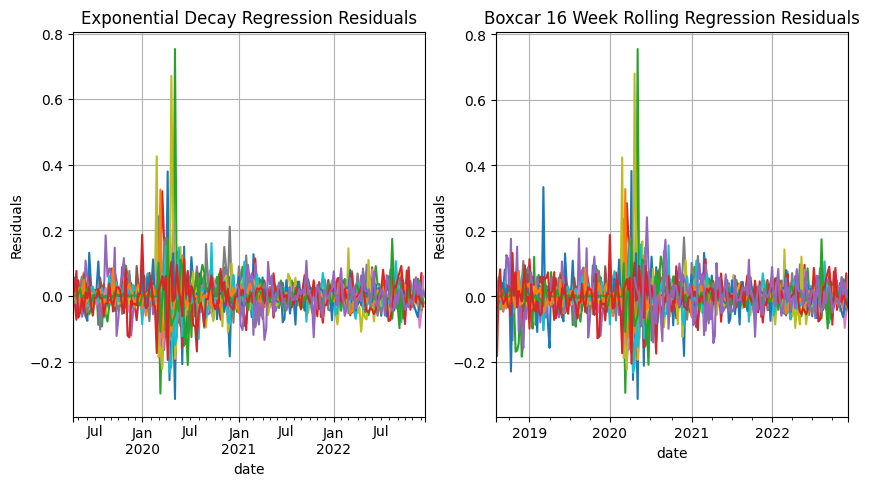

In [466]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # create a figure with two subplots

for key, df in exponential_residuals_of_residuals_dict.items(): # iterate through the dataframes in dict1
    df[0].plot(ax=axes[0], label = key) # plot each dataframe in the first subplot

for key, df in boxcar_residuals_of_residuals_dict.items(): # iterate through the dataframes in dict2
    df[0].plot(ax=axes[1], label = key) # plot each dataframe in the second subplot

# customize the plot
axes[0].set_title('Exponential Decay Regression Residuals')
axes[0].set_ylabel('Residuals')
axes[1].set_title('Boxcar 16 Week Rolling Regression Residuals')
axes[1].set_ylabel('Residuals')
axes[0].grid()
axes[1].grid()
plt.show() # display the plot

As one can observe, the residuals seem to be very similar across both of the regressions, with huge spikes at similar times, primarily early 2020 when the COVID pandemic started. I will discuss more about the effects of the pandemic on predictions later.

For closer examination of residual difference between the models below I have looped through the tickers to see which model produces the lowest standard deviation, minimum and maximum of residuals on average.

In [467]:
description = pd.DataFrame(index = tickers, columns = ['Exponential std', 'Boxcar std', 'Exponential max', 'Boxcar max', 'Exponential min', 'Boxcar min'])
for ticker in tickers:
    x = exponential_residuals_of_residuals_dict[ticker].describe()
    y = boxcar_residuals_of_residuals_dict[ticker].describe()
    description.loc[ticker, 'Exponential std'] = x.loc['std', 0]
    description.loc[ticker, 'Exponential max'] = x.loc['max', 0]
    description.loc[ticker, 'Exponential min'] = x.loc['min', 0]
    description.loc[ticker, 'Boxcar std'] = y.loc['std', 0]
    description.loc[ticker, 'Boxcar max'] = y.loc['max', 0]
    description.loc[ticker, 'Boxcar min'] = y.loc['min', 0]
description

,Exponential std,Boxcar std,Exponential max,Boxcar max,Exponential min,Boxcar min
BA,0.067904,0.068457,0.37958,0.382839,-0.313952,-0.313936
C,0.031052,0.030569,0.160118,0.154565,-0.161594,-0.171036
DD,0.072343,0.07299,0.752827,0.755383,-0.29711,-0.295249
F,0.052029,0.050015,0.319251,0.284488,-0.195319,-0.19677
GE,0.050931,0.055608,0.22,0.220291,-0.165171,-0.165626
JPM,0.030893,0.030146,0.159163,0.152104,-0.120023,-0.110235
LNC,0.033993,0.032338,0.080738,0.080938,-0.21509,-0.206818
LOW,0.048816,0.044951,0.211391,0.179888,-0.126909,-0.129898
LUV,0.077049,0.071905,0.670994,0.680728,-0.222482,-0.224807
MAR,0.048662,0.046597,0.161311,0.158124,-0.232699,-0.233586


In [468]:
fraction = pd.DataFrame(index = ['Exponential', 'Boxcar'], columns = ['Larger std', 'Larger magnitude min', 'Larger magnitude max'])
fraction.loc['Exponential','Larger std'] = len(description[description['Boxcar std'] < description['Exponential std']])/len(tickers)
fraction.loc['Exponential','Larger magnitude min'] = len(description[description['Boxcar min'] > description['Exponential min']])/len(tickers)
fraction.loc['Exponential','Larger magnitude max'] = len(description[description['Boxcar max'] < description['Exponential max']])/len(tickers)
fraction.loc['Boxcar', 'Larger std'] = 1-fraction.loc['Exponential', 'Larger std']
fraction.loc['Boxcar', 'Larger magnitude min'] = 1-fraction.loc['Exponential', 'Larger magnitude min']
fraction.loc['Boxcar', 'Larger magnitude max'] = 1-fraction.loc['Exponential', 'Larger magnitude max']
fraction

,Larger std,Larger magnitude min,Larger magnitude max
Exponential,0.6,0.333333,0.333333
Boxcar,0.4,0.666667,0.666667


This is interesting as my epxonential decay regression has generally slightly larger standard deviations of residuals yet a smaller proportion of the largest maximum and minimum. From this I can infer that my boxcar regressions may have genearlly very small and closer residuals but potentially more outliers than the exopnential decay regressions. 

### Tail Risk

In [469]:
def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR = (VaR - returns.mean())/returns.std()
        CVaR = (CVaR - returns.mean())/returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR


    return metrics

In [470]:
exponential_tail_risk = pd.DataFrame(index = tickers, columns = ['Skewness', 'Kurtosis', 'VaR (0.05)', 'CVaR (0.05)'])
for ticker in tickers:
    for stat in ['Skewness', 'Kurtosis', 'VaR (0.05)', 'CVaR (0.05)']:
        x = tailMetrics(exponential_residuals_of_residuals_dict[ticker])
        exponential_tail_risk.loc[ticker][stat] = x[stat][0]
        boxcar_tail_risk = pd.DataFrame(index = tickers, columns = ['Skewness', 'Kurtosis', 'VaR (0.05)', 'CVaR (0.05)'])
for ticker in tickers:
    for stat in ['Skewness', 'Kurtosis', 'VaR (0.05)', 'CVaR (0.05)']:
        x = tailMetrics(boxcar_residuals_of_residuals_dict[ticker])
        boxcar_tail_risk.loc[ticker][stat] = x[stat][0]
exponential_tail_risk.loc['Average'] = exponential_tail_risk.mean()
boxcar_tail_risk.loc['Average'] = boxcar_tail_risk.mean()

Below are the tail metrics for both my exponential decay model (first) and my boxcar model (second) for residuals when using my residuals to predict residuals

In [471]:
exponential_tail_risk

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05)
BA,0.180703,8.879448,-0.074047,-0.167933
C,-0.175981,7.481168,-0.046139,-0.074041
DD,5.295743,60.756227,-0.078412,-0.12704
F,0.853361,8.582494,-0.072824,-0.115876
GE,0.263743,3.45586,-0.066447,-0.119082
JPM,0.441594,4.426495,-0.047586,-0.067306
LNC,-1.996097,10.623073,-0.047117,-0.095128
LOW,0.889471,3.037176,-0.077943,-0.093415
LUV,4.244401,35.275579,-0.090056,-0.142144
MAR,-0.681567,5.581684,-0.078729,-0.129888


In [472]:
boxcar_tail_risk

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05)
BA,0.580948,9.488121,-0.077798,-0.162197
C,-0.264545,7.22001,-0.044231,-0.071298
DD,4.346532,51.323675,-0.09651,-0.153178
F,0.487639,6.092551,-0.073291,-0.110912
GE,0.223317,2.327638,-0.086784,-0.127154
JPM,0.376962,3.424044,-0.04865,-0.065986
LNC,-1.834201,10.151928,-0.046479,-0.087331
LOW,0.615894,2.358995,-0.069677,-0.089983
LUV,4.549127,41.300953,-0.085669,-0.132848
MAR,-0.662986,5.82749,-0.075237,-0.120841


Generally, the skew is small and slightly more frequently positive. This makes sense as the majority of residuals we expect to be very small and close to zero. We also want normally destributed residuals to assume that our model is good and accurate. This confirms my data above that boxcar regression seems to have slightly more normal residuals with smaller skew and kurtosis, but it has a more extreme VaR and CvAR, confirming that my boxcar regression potentially has the larger outliers. 

Below I have plotted the most extreme case of skew and kurtosis, DD, to analyze it.

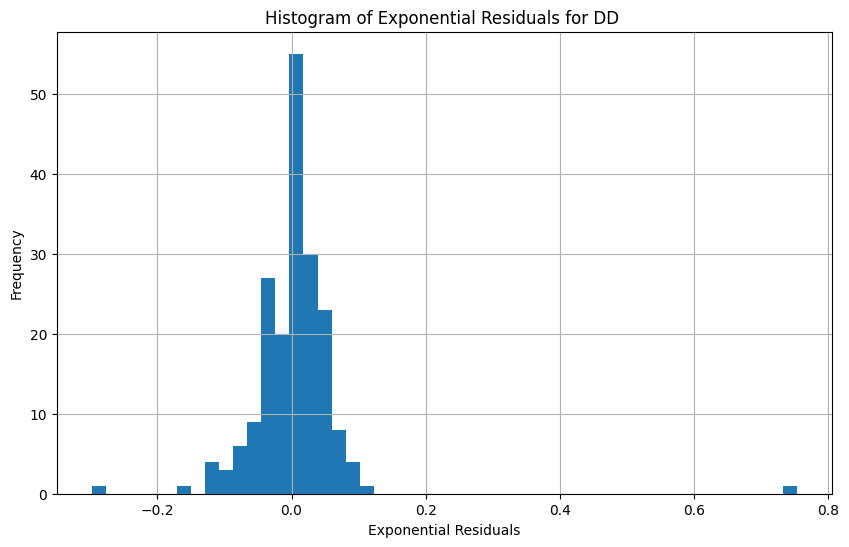

In [473]:
plt.figure(figsize=(10, 6))
plt.hist(exponential_residuals_of_residuals_dict['DD'], bins=50)

# Add a title and axis labels
plt.title("Histogram of Exponential Residuals for DD " )
plt.xlabel("Exponential Residuals")
plt.ylabel("Frequency")
plt.grid()
# Display the histogram
plt.show()

As  you can see, the main reason for the extreme values given by the tail risk function is that one outlier of a residual close to .8 which happened March/April 2020 at the start of the Covid 19 pandemic. 

### Comparing Different Boxcar Model Parameters

I conducted my final residual regression initially using the 16 week rolling window but then after conducted it with 10 weeks and 20 weeks to compare between the parameters. Below I have plotted the 10, 16 and 20 week boxcar residuals for the tickers BA and T

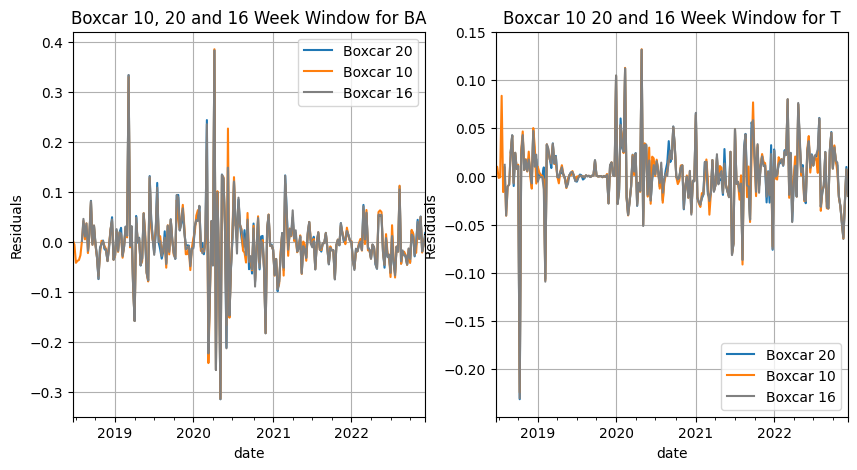

In [474]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # create a figure with two subplots

boxcar_residuals_of_residuals_dict_20['BA'][0].plot(ax=axes[0], label = 'Boxcar 20') # plot each dataframe in the first subplot
boxcar_residuals_of_residuals_dict_10['BA'][0].plot(ax=axes[0], label = 'Boxcar 10')
boxcar_residuals_of_residuals_dict['BA'][0].plot(ax=axes[0], label = 'Boxcar 16', color = 'grey')

boxcar_residuals_of_residuals_dict_20['T'][0].plot(ax=axes[1], label = 'Boxcar 20') # plot each dataframe in the first subplot
boxcar_residuals_of_residuals_dict_10['T'][0].plot(ax=axes[1], label = 'Boxcar 10')
boxcar_residuals_of_residuals_dict['T'][0].plot(ax=axes[1], label = 'Boxcar 16', color = 'grey')


axes[0].set_title('Boxcar 10, 20 and 16 Week Window for BA')
axes[0].set_ylabel('Residuals')
axes[1].set_title('Boxcar 10 20 and 16 Week Window for T')
axes[1].set_ylabel('Residuals')
axes[0].legend()
axes[1].legend()
axes[1].grid()
axes[0].grid()
plt.show()


As assumed, there is not much difference to be seen at the surface level between these models as they are very similar, just different rolling week sizes. Below I dive a little deeper into std and mean of each tickers residuals for each model

In [475]:
test = pd.DataFrame(index = tickers, columns = ['Boxcar 10 std', 'Boxcar 16 std', 'Boxcar 20 std', 'Boxcar 10 mean', 'Boxcar 16 mean', 'Boxcar 20 mean'])
for ticker in tickers:
    x = boxcar_residual_model_dict_10[ticker].describe()
    y = boxcar_residual_model_dict[ticker].describe()
    z = boxcar_residual_model_dict_20[ticker].describe()
    test.loc[ticker]['Boxcar 10 std'] = x.loc['std']['equity residual']
    test.loc[ticker]['Boxcar 16 std'] = y.loc['std']['equity residual']
    test.loc[ticker]['Boxcar 20 std'] = z.loc['std']['equity residual']
    test.loc[ticker]['Boxcar 10 mean'] = x.loc['mean']['equity residual']
    test.loc[ticker]['Boxcar 16 mean'] = y.loc['mean']['equity residual']
    test.loc[ticker]['Boxcar 20 mean'] = z.loc['mean']['equity residual']
test.loc['Average'] = test.mean()
test

,Boxcar 10 std,Boxcar 16 std,Boxcar 20 std,Boxcar 10 mean,Boxcar 16 mean,Boxcar 20 mean
BA,0.371902,0.281468,0.253471,-0.274621,-0.26348,-0.256587
C,0.349496,0.317795,0.303825,-0.050098,-0.029971,-0.026834
DD,0.576191,0.43825,0.390749,-0.213309,-0.25063,-0.26971
F,0.342998,0.260736,0.224553,-0.143693,-0.144811,-0.136806
GE,0.386815,0.312063,0.272924,-0.128104,-0.123779,-0.121019
JPM,0.325714,0.279092,0.263175,0.001758,0.004055,0.001898
LNC,0.309782,0.23919,0.215215,0.003006,-0.01551,-0.014017
LOW,0.577892,0.556768,0.569173,-0.210863,-0.155481,-0.123728
LUV,0.466304,0.398264,0.376935,-0.384242,-0.421239,-0.441491
MAR,0.424934,0.312333,0.252452,-0.233627,-0.248643,-0.273931


It is interesting to not that the 20 week boxcar has the smallest average standard deviation which makes conceptual since as there is more data going into its predictions, but the boxcar 10 week has the smallest (in magnitude) average mean (barely). Genearlly, for residuals we want a mean closest to zero as we want our residuals to be normally distributed. In both of these statistics, the 16 week is the middle ground for 'best' model.

### Comparing Different Exponential Decay Model Parameters

As with boxcar, I conducted my final regression using three different exponential decay halflife parameters. I used a half life of 6, 9 and 12, and will compare them below. First I graphed the residuals for the three different models for two random tickers

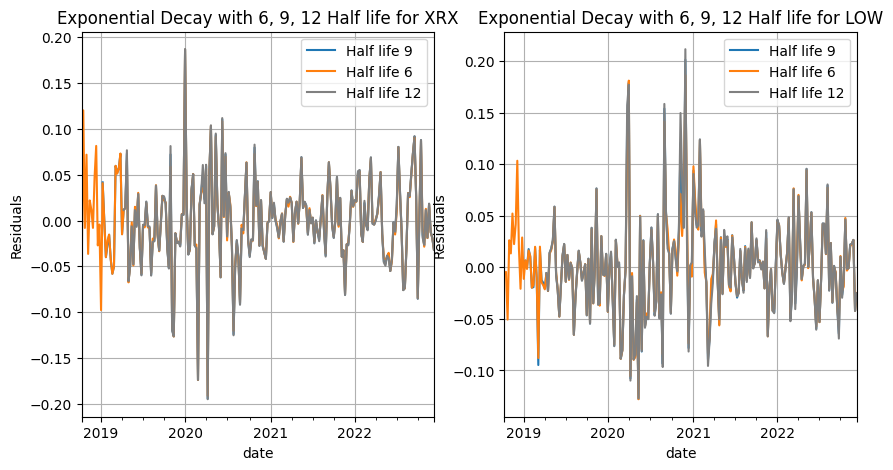

In [476]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # create a figure with two subplots

exponential_residuals_of_residuals_dict_9['XRX'][0].plot(ax=axes[0], label = 'Half life 9') # plot each dataframe in the first subplot
exponential_residuals_of_residuals_dict_6['XRX'][0].plot(ax=axes[0], label = 'Half life 6')
exponential_residuals_of_residuals_dict['XRX'][0].plot(ax=axes[0], label = 'Half life 12', color = 'grey')

exponential_residuals_of_residuals_dict_9['LOW'][0].plot(ax=axes[1], label = 'Half life 9') # plot each dataframe in the first subplot
exponential_residuals_of_residuals_dict_6['LOW'][0].plot(ax=axes[1], label = 'Half life 6')
exponential_residuals_of_residuals_dict['LOW'][0].plot(ax=axes[1], label = 'Half life 12', color = 'grey')


axes[0].set_title('Exponential Decay with 6, 9, 12 Half life for XRX')
axes[0].set_ylabel('Residuals')
axes[1].set_title('Exponential Decay with 6, 9, 12 Half life for LOW')
axes[1].set_ylabel('Residuals')
axes[0].legend()
axes[1].legend()
axes[1].grid()
axes[0].grid()
plt.show()


Much like in boxcar, they appear very similar in graphs since they are extremely close to one another. Below I will do more analysis on the means and standard deviations

In [477]:
test = pd.DataFrame(index = tickers, columns = ['Exponential 6 std', 'Exponential 9 std', 'Exponential 12 std', 'Exponential 6 mean', 'Exponential 9 mean', 'Exponential 12 mean'])
for ticker in tickers:
    x = exponential_residual_model_dict_6[ticker].describe()
    y = exponential_residual_model_dict_9[ticker].describe()
    z = exponential_residual_model_dict[ticker].describe()
    test.loc[ticker]['Exponential 6 std'] = x.loc['std']['equity residual']
    test.loc[ticker]['Exponential 9 std'] = y.loc['std']['equity residual']
    test.loc[ticker]['Exponential 12 std'] = z.loc['std']['equity residual']
    test.loc[ticker]['Exponential 6 mean'] = x.loc['mean']['equity residual']
    test.loc[ticker]['Exponential 9 mean'] = y.loc['mean']['equity residual']
    test.loc[ticker]['Exponential 12 mean'] = z.loc['mean']['equity residual']
test.loc['Average'] = test.mean()
test

,Exponential 6 std,Exponential 9 std,Exponential 12 std,Exponential 6 mean,Exponential 9 mean,Exponential 12 mean
BA,0.281694,0.244238,0.220861,-0.240792,-0.225182,-0.214159
C,0.288791,0.24778,0.226868,-0.035534,-0.043156,-0.052493
DD,0.38366,0.253135,0.226352,-0.277769,-0.255605,-0.253939
F,0.252319,0.192851,0.156266,-0.132872,-0.126849,-0.119945
GE,0.271629,0.221176,0.176406,-0.117476,-0.127385,-0.145604
JPM,0.265796,0.2322,0.213165,-0.004155,-0.00045,-0.007188
LNC,0.208113,0.165535,0.139863,-0.005545,-0.012514,-0.017253
LOW,0.534789,0.522265,0.507446,-0.106385,-0.046796,0.010205
LUV,0.382837,0.337102,0.309894,-0.470024,-0.50223,-0.534697
MAR,0.232399,0.183759,0.16351,-0.264166,-0.295991,-0.315522


The results here are almost identical to that of the boxcar regressions where the regression with the largest half life has the smallest average standard deviation yet the regression with the smallest half life has the smallest magnitude of the average of means. From this we can potentially infer than increasing your parameters for these regressions (rolling windows and halflife) results in less variance in residuals but potentially larger mean residuals. 

### Covid 19

As noticed in much of my data, the covid 19 pandemic skewed a lot of my predictions. Predictive models of this type perform very poorly during these times as there is no indication to the model as to what is happening outside of the data. Obviously, the model is able to train and correct itself slightly but this results in very large residuals during these time periods. As seen below, for the ticker 'BA,' average cds returns were .0183. During the covid spike, we saw a gain of 2.81 which is an extreme outlier that would never be predicted by my model. This also results in my model using this 2.8 data point in its next predictions, skewing the later predictions and increasing their residuals as well. Below is the BA CDS return statistics and then below that is the returns from february to april of 2020

In [478]:
df_dict['BA']['r_cds'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
r_cds,261.0,0.018317,0.201269,-0.254334,-0.045918,0.000545,0.039519,2.810448


In [479]:
df_dict['BA'].loc[pd.to_datetime('2020-02-10'):pd.to_datetime('2020-04-20')][['r_cds']].T

date,2020-02-12,2020-02-19,2020-02-26,2020-03-04,2020-03-11,2020-03-18,2020-03-25,2020-04-01,2020-04-08,2020-04-15
r_cds,-0.01752,0.126777,0.127394,2.810448,0.857174,0.01761,-0.198614,-0.094884,-0.254334,-0.004011


Below, I have plotted My predicted CDS residuals vs the actual residuals, and my predicted CDS returns vs the actual. The graph on the left would for the actual residuals would be the difference between the two lines on the right.

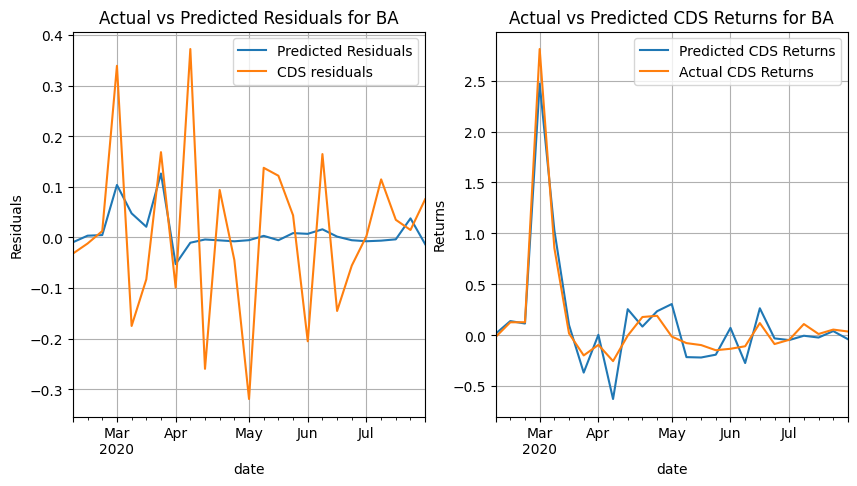

In [480]:


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # create a figure with two subplots

boxcar_predictions.loc[pd.to_datetime('2020-02-10'):pd.to_datetime('2020-07-30')]['BA'].plot(ax=axes[0], label = 'Predicted Residuals') # plot each dataframe in the first subplot
final_residuals['BA'].loc[pd.to_datetime('2020-02-10'):pd.to_datetime('2020-07-30')]['cds residual'].plot(ax=axes[0], label = 'CDS residuals')
predicted_returns_1['BA'].loc[pd.to_datetime('2020-02-10'):pd.to_datetime('2020-07-30')]['rets'].plot(ax = axes[1], label = 'Predicted CDS Returns')
df_dict['BA'].loc[pd.to_datetime('2020-02-10'):pd.to_datetime('2020-07-30')]['r_cds'].plot(ax = axes[1], label = 'Actual CDS Returns')
axes[0].set_title('Actual vs Predicted Residuals for BA')
axes[0].set_ylabel('Residuals')
axes[1].set_title('Actual vs Predicted CDS Returns for BA')
axes[1].set_ylabel('Returns')
axes[0].legend()
axes[1].legend()
axes[1].grid()
axes[0].grid()
plt.show()


As you can see, my model actually does a fairly solid job in making these predictions, but since the magnitude is so much higher, the slightest difference is massive compared to normal residuals. Events such as Covid genearlly lead to big issues in predictive models as they take in this extreme swing as 'normal' and use this data to make predictions in the future.

# 4 CONCLUSIONS

While the boxcar and exponential decay regressions are very similar, our analysis has exposed a few of the main differences. First, I found that exponential decay regressions are going to have slightly larger standard deviations of residuals but less extreme points. Meaning that they may not be as accurate all the time but they are rarely going to have days with huge descrepencies. This means that my boxcar regressions generally had smaller standard deviations but larger extreme values. 

Within each type of regression, the larger the parameter (rolling window or half life), the smaller the standard deviation which makes sense given we are taking in more data to make our predictions.

A lof of this data is very skewed because of the fluctuations around the time of the covid pandemic. it would be intereting to test the predictive power of these regressions in a time period that excluded Covid-19. Another way of improving this analysis would be to train the data on a certain set of data and test it on another, and maximize our paremeters to reduce mean squared error (although this may potentially overfit our data).